### Imports

In [5]:
import perceval as pcvl
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from perceval.algorithm import Sampler
from tqdm import tqdm
from perceval.components.unitary_components import PS, BS, PERM

# Use the symbolic skin for display
from perceval.rendering.circuit import DisplayConfig, SymbSkin
from perceval.rendering.format import Format
DisplayConfig.select_skin(SymbSkin)

# Imports for the fitting
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

# Set the plot parameters to make us look good in the presentation

In [14]:
FIGURE_WIDTH_1COL = 3.404  # For PRX style, change for according to journal
FIGURE_WIDTH_2COL = 7.057  # For PRX style, change for according to journal
FIGURE_HEIGHT_1COL_GR = FIGURE_WIDTH_1COL*2/(1 + np.sqrt(5))
FIGURE_HEIGHT_2COL_GR = FIGURE_WIDTH_2COL*2/(1 + np.sqrt(5))

font_size = 6 # For PRX style, change for according to journal

plt.rcParams.update({
    'font.size'           : font_size,  
    'figure.titlesize'    : 'medium',
    'figure.dpi'          : 1000,
    'figure.figsize'      : (FIGURE_WIDTH_1COL, FIGURE_HEIGHT_1COL_GR),
    'axes.titlesize'      : 'medium',
    'axes.axisbelow'      : True,
    'xtick.direction'     : 'in',
    'xtick.labelsize'     : 'small',
    'ytick.direction'     : 'in',
    'ytick.labelsize'     : 'small',
    'image.interpolation' : 'none',
    'legend.fontsize': font_size,
    'axes.labelsize': font_size,
    'axes.titlesize': font_size,
    'xtick.labelsize': font_size,
    'ytick.labelsize': font_size,
})


plt.rcParams.update({'font.family':'sans-serif'})

### Load our data

We use tidal data on the Irish Coast in Dublin. 

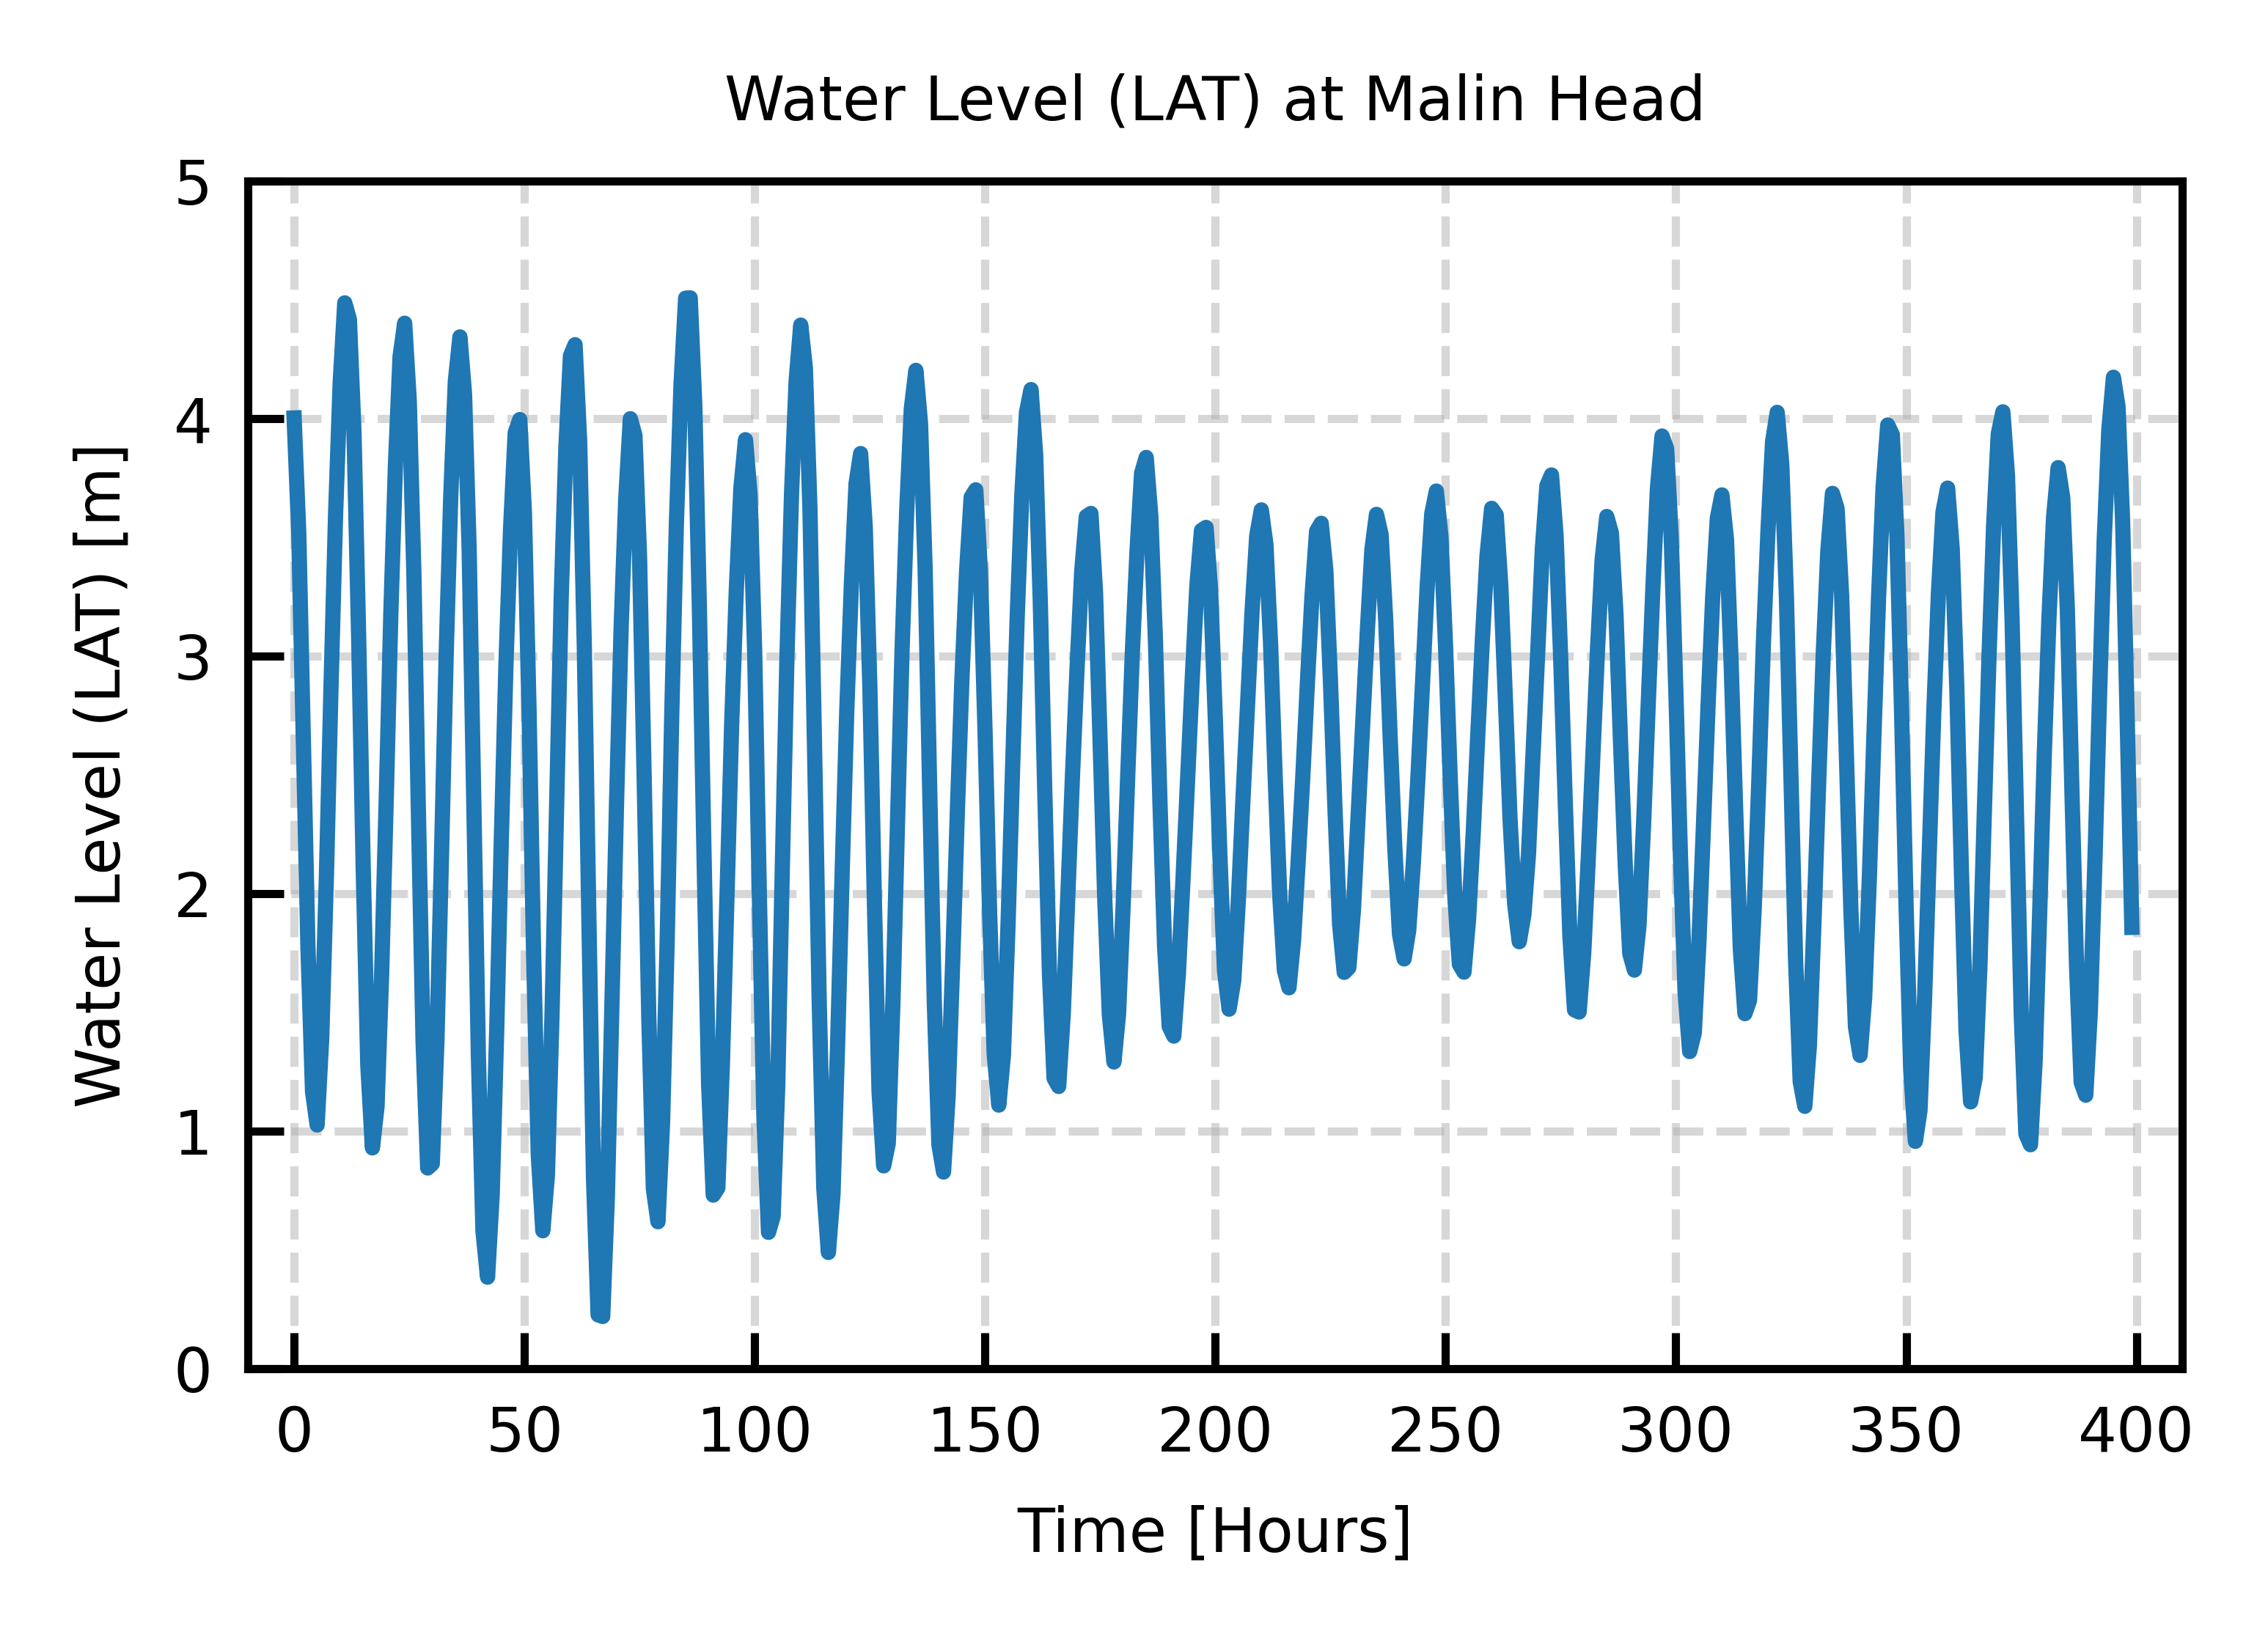

In [19]:
data = pd.read_csv("IrishNationalTideGaugeNetwork_070c_f250_eaf8.csv")
data = data["Water_Level_LAT"].drop(0).astype(float)
data = data.groupby(data.index // 12).mean()[:400]

plt.plot(data.index, data.values)
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')
plt.title('Water Level (LAT) at Malin Head')
plt.grid(linestyle='--', alpha=0.5)
plt.xlim(-10, 410)
plt.ylim(0,5)
plt.show()

# Now let's get into the juicy details of physics

We use a processor with five modes and one ancilla. 

In [ ]:
def set_processor_parameters(processor, parameter_matrix):
    """
    Set the parameters of the processor to the values in the matrix.

    Args:
        processor (Processor): The processor to set the parameters for.
        parameter_matrix (np.ndarray): A matrix of size (t, num_parameters).

    Description:
        The parameter matrix is flattened to match the list of parameters.
        The parameters are set in the order they appear in the circuit.
    """
    flattened_params = parameter_matrix.flatten()
    params = list(processor.get_circuit_parameters().values())
    assert len(params) == len(
        flattened_params), f"Parameter length mismatch. Expected {len(params)} parameters, got {len(flattened_params)}."
    for param, value in zip(params, flattened_params):
        param.set_value(value)

### Set constants for our circuit

In [7]:
# Constants
N_MODES = 5
NUM_ANCILLAS = 1
INIT_PHOTON_NUMBER = 2
INIT_STATE = [0, 0, 0, 0, 0] + [INIT_PHOTON_NUMBER]
print(f"Initial state for new run {INIT_STATE}")
SCALE = 0.01
LOSS = 0.4
BS_INDEX = [3,2,1,0]
print("Beamsplitter arrangement", BS_INDEX)

Initial state for new run [0, 0, 0, 0, 0, 2]
Beamsplitter arrangement [3, 2, 1, 0]


In [ ]:
processor = pcvl.Processor("SLOS", len(INIT_STATE))
    
# add a Mach Zehnder interferometer to inject the data
angle = data_renormalized[i]*2*np.pi
print(f"Angle {angle}")
processor.add(N_MODES-1, pcvl.BS().add(0, pcvl.PS(phi=angle)).add(0, pcvl.BS()))
print(f"Prob for upper {np.cos(angle/2)**2}")

# add a beamsplitter cascade to ensure full connectivity
for j, index in enumerate(BS_INDEX):
    processor.add(index, pcvl.BS(pcvl.P(f"theta_{j}")))
# add loss channel to each mode
for k in range(N_MODES):
    processor.add(k, pcvl.LC(LOSS))

# parameter_matrix = np.random.normal(loc=data_renormalized[i], scale=SCALE, size=len(BS_INDEX)) * 2 * np.pi
set_processor_parameters(processor, parameter_matrix)
processor.with_input(pcvl.BasicState(INIT_STATE))

In [ ]:


# Normalize data
data_renormalized = (data - min(data)) / (max(data) - min(data))
data_renormalized = data_renormalized.to_numpy()

# data_renorm_red = data_renormalized[::10]

# Initialize expectation matrix
expectation_matrix = np.zeros((len(data_renormalized), N_MODES))
parameter_matrix = np.ones(len(BS_INDEX)) * np.pi 

# Main loop for circuit construction and simulation
for i in tqdm(range(len(data_renormalized)), desc="Computing layer"):
    processor = pcvl.Processor("SLOS", len(INIT_STATE))
    
    # add a Mach Zehnder interferometer to inject the data
    angle = data_renormalized[i]*2*np.pi
    print(f"Angle {angle}")
    processor.add(N_MODES-1, pcvl.BS().add(0, pcvl.PS(phi=angle)).add(0, pcvl.BS()))
    print(f"Prob for upper {np.cos(angle/2)**2}")

    # add a beamsplitter cascade to ensure full connectivity
    for j, index in enumerate(BS_INDEX):
        processor.add(index, pcvl.BS(pcvl.P(f"theta_{j}")))
    # add loss channel to each mode
    for k in range(N_MODES):
        processor.add(k, pcvl.LC(LOSS))

    # parameter_matrix = np.random.normal(loc=data_renormalized[i], scale=SCALE, size=len(BS_INDEX)) * 2 * np.pi
    set_processor_parameters(processor, parameter_matrix)
    processor.with_input(pcvl.BasicState(INIT_STATE))

    # Simulate and sample the circuit
    sampler = pcvl.algorithm.Sampler(processor)
    prob_distribution = sampler.probs()['results']
    # prob_distribution = filter_keys_with_sum_one(prob_distribution)

    # Calculate expectations
    expectations = [0.0 for _ in range(N_MODES)]
    for state, probability in prob_distribution.items():
        for mode in range(N_MODES):
            expectations[mode] += state[mode] * probability
    expectation_matrix[i,:] = expectations
    # print(f"Expectations {expectations}")
    print(f"Most probable state: {max(prob_distribution, key=prob_distribution.get)}")
    # Update initial state for the next iteration
    INIT_STATE = list(max(prob_distribution, key=prob_distribution.get))[:N_MODES] + [INIT_PHOTON_NUMBER]
    print(f"Init state for new run {INIT_STATE}")

# Display the final circuit
print("Expectation matrix shape", expectation_matrix.shape)
print("Final circuit")
pcvl.pdisplay(processor, recursive=True)